## Notebook Imports

In [90]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

## Constants

In [24]:
EXAMPLE_FILE = "../data/SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "../data/SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "../data/SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "../data/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "../data/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = "../data/SpamData/01_Processing/email-text-data.json"

## Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding="latin-1")


is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == "\n":
        is_body = True
        
stream.close()

email_body = "\n".join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

## Generator Functions

In [5]:
def generate_square(N):
    for my_number in range(N):
        yield my_number ** 2

In [6]:
for i in generate_square(5):
    print(i, end=" ->")

0 ->1 ->4 ->9 ->16 ->

### Email body extraction

In [7]:
def email_body_generator(path):
    for root, dirnames, filename in walk(path):
        for file_name in filename:
            
            filepath = join(root, file_name)
                       
            stream = open(filepath, encoding="latin-1")
            
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True

            stream.close()

            email_body = "\n".join(lines)
            
            yield file_name, email_body


In [8]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)
    

In [9]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,1))
spam_emails.head()

,MESSAGE,CATEGORY
00387.8562ea27520ea0fa6030679792f2fb72,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00313.fab744bfd5a128fca39b69df9811c086,PGh0bWw+DQo8aGVhZD4NCjxtZXRhIGh0dHAtZXF1aXY9Ik...,1
00365.da6795d02b44e4d5e168d62718f3e7c9,--------------103237257898946\n\nContent-Type:...,1
00255.aeff2fdf2ba6b8b49686df3575859a48,It was the Spring of 1979. \n\n\n\nI was just...,1
00248.b243bca51ee69d6e428ca2f45f0fe41b,This is a multi-part message in MIME format.\n...,1


In [10]:
spam_emails.shape

(1898, 2)

In [11]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is ", data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00387.8562ea27520ea0fa6030679792f2fb72,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00313.fab744bfd5a128fca39b69df9811c086,PGh0bWw+DQo8aGVhZD4NCjxtZXRhIGh0dHAtZXF1aXY9Ik...,1
00365.da6795d02b44e4d5e168d62718f3e7c9,--------------103237257898946\n\nContent-Type:...,1
00255.aeff2fdf2ba6b8b49686df3575859a48,It was the Spring of 1979. \n\n\n\nI was just...,1
00248.b243bca51ee69d6e428ca2f45f0fe41b,This is a multi-part message in MIME format.\n...,1


In [13]:
data.tail()

,MESSAGE,CATEGORY
00515.b39512509fd4f39fb1cf50248c37564f,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0
01269.4b518a53f76da3fd4d469c5e2e557340,"On Wed, 21 Aug 2002 10:38:04 +0200, Matthias S...",0
00307.6cfae2c5703c7eb36db9c8158c70b0ae,"On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...",0
00212.df5211161d938a2547804a50f0a8698f,"At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...",0
01316.ba750fd796b2557fbfbbd3699ff90d25,use Perl Daily Newsletter\n\n\n\nIn this issue...,0


## Data Cleaning: Checking for Missing Values

In [14]:
data

,MESSAGE,CATEGORY
00387.8562ea27520ea0fa6030679792f2fb72,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00313.fab744bfd5a128fca39b69df9811c086,PGh0bWw+DQo8aGVhZD4NCjxtZXRhIGh0dHAtZXF1aXY9Ik...,1
00365.da6795d02b44e4d5e168d62718f3e7c9,--------------103237257898946\n\nContent-Type:...,1
00255.aeff2fdf2ba6b8b49686df3575859a48,It was the Spring of 1979. \n\n\n\nI was just...,1
00248.b243bca51ee69d6e428ca2f45f0fe41b,This is a multi-part message in MIME format.\n...,1
...,...,...
00515.b39512509fd4f39fb1cf50248c37564f,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0
01269.4b518a53f76da3fd4d469c5e2e557340,"On Wed, 21 Aug 2002 10:38:04 +0200, Matthias S...",0
00307.6cfae2c5703c7eb36db9c8158c70b0ae,"On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...",0
00212.df5211161d938a2547804a50f0a8698f,"At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...",0


In [15]:
data["MESSAGE"]

00387.8562ea27520ea0fa6030679792f2fb72    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
00313.fab744bfd5a128fca39b69df9811c086    PGh0bWw+DQo8aGVhZD4NCjxtZXRhIGh0dHAtZXF1aXY9Ik...
00365.da6795d02b44e4d5e168d62718f3e7c9    --------------103237257898946\n\nContent-Type:...
00255.aeff2fdf2ba6b8b49686df3575859a48    It was the Spring of 1979.  \n\n\n\nI was just...
00248.b243bca51ee69d6e428ca2f45f0fe41b    This is a multi-part message in MIME format.\n...
                                                                ...                        
00515.b39512509fd4f39fb1cf50248c37564f    On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...
01269.4b518a53f76da3fd4d469c5e2e557340    On Wed, 21 Aug 2002 10:38:04 +0200, Matthias S...
00307.6cfae2c5703c7eb36db9c8158c70b0ae    On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...
00212.df5211161d938a2547804a50f0a8698f    At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...
01316.ba750fd796b2557fbfbbd3699ff90d25    use Perl Daily Newsletter\n\n\n\nIn th

In [16]:
data["MESSAGE"].isnull().value_counts()

False    5799
Name: MESSAGE, dtype: int64

In [17]:
data["MESSAGE"].isnull().values.any()

False

In [18]:
# Check if there are empty emails (string lengh zero)
(data.MESSAGE.str.len() == 0).any()

True

In [19]:
(data.MESSAGE.str.len() == 0).value_counts()

False    5796
True        3
Name: MESSAGE, dtype: int64

### Local empty emails

In [20]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

### Remove system file entries from dataframe

In [21]:
data.drop(["cmds"], inplace=True)
data.shape

(5796, 2)

### Add Documents IDs to track Emails in Dataset

In [22]:
documents_ids = range(0,len(data.index))
data["DOC_ID"] = documents_ids

In [23]:
data["FILE_NAME"] = data.index
data.set_index("DOC_ID", inplace=True)
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00387.8562ea27520ea0fa6030679792f2fb72
1,PGh0bWw+DQo8aGVhZD4NCjxtZXRhIGh0dHAtZXF1aXY9Ik...,1,00313.fab744bfd5a128fca39b69df9811c086
2,--------------103237257898946\n\nContent-Type:...,1,00365.da6795d02b44e4d5e168d62718f3e7c9
3,It was the Spring of 1979. \n\n\n\nI was just...,1,00255.aeff2fdf2ba6b8b49686df3575859a48
4,This is a multi-part message in MIME format.\n...,1,00248.b243bca51ee69d6e428ca2f45f0fe41b
...,...,...,...
5791,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0,00515.b39512509fd4f39fb1cf50248c37564f
5792,"On Wed, 21 Aug 2002 10:38:04 +0200, Matthias S...",0,01269.4b518a53f76da3fd4d469c5e2e557340
5793,"On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...",0,00307.6cfae2c5703c7eb36db9c8158c70b0ae


### Save to File using Pandas

In [25]:
data.to_json(DATA_JSON_FILE)

### Number of Spam Messages Visualised (Pie Chart)

In [26]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [34]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

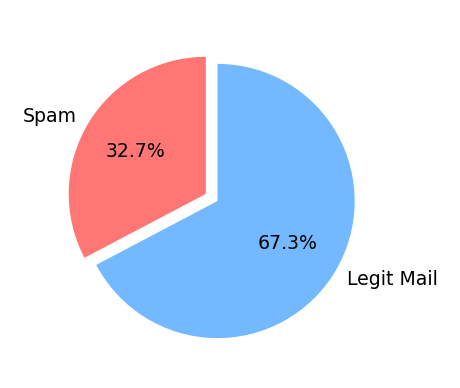

In [57]:
category_name = ["Spam","Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#ff7675","#74b9ff"]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name, textprops={"fontsize":6}, 
        startangle=90, 
        autopct="%1.1f%%",
       colors=custom_colours, explode=[0,0.1])
plt.show()

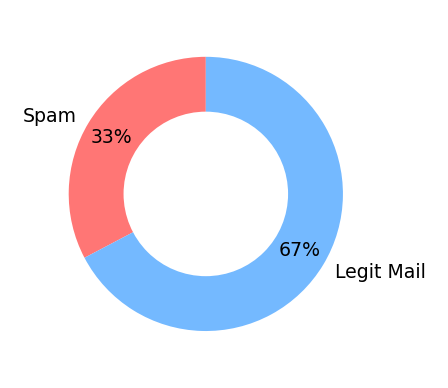

In [62]:
category_name = ["Spam","Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#ff7675","#74b9ff"]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name, textprops={"fontsize":6}, 
        startangle=90, 
        autopct="%1.f%%",
       colors=custom_colours,
       pctdistance=0.8)

# Draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc="white")
plt.gca().add_artist(centre_circle)

plt.show()

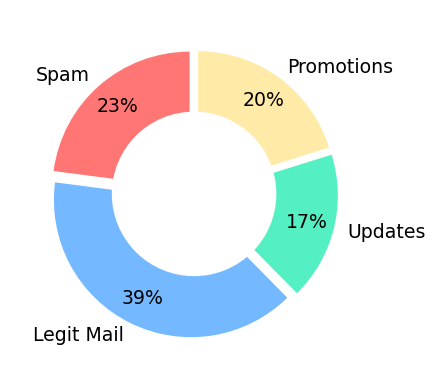

In [64]:
category_name = ["Spam","Legit Mail","Updates","Promotions"]
sizes= [25,43,19,22]
custom_colours = ["#ff7675","#74b9ff","#55efc4","#ffeaa7"]
offset = [0.05,0.05,0.05,0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name, textprops={"fontsize":6}, 
        startangle=90, 
        autopct="%1.f%%",
       colors=custom_colours,
       pctdistance=0.8, explode=offset)

# Draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc="white")
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing
### Text Pre-Processing

In [65]:
msg = "All work and no play makes Jack a dull boy"
msg.lower()

'all work an no play makes jack a dull boy'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [69]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/sjvasconcello/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [72]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sjvasconcello/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Tokenising

In [71]:
msg = "All work and no play makes Jack a dull boy"
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

## Removing Stop Words

In [79]:
stop_words = set(stopwords.words("english"))

In [80]:
type(stop_words)

set

In [82]:
if "this" in stop_words: print("Found it!")

Found it!


In [85]:
if "hello" not in  stop_words: print("Nope!")

Nope!


In [93]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

stemmer = SnowballStemmer("english")

filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']
